In [0]:
#default_exp gaussian

In [0]:
#Run once per session
import os
!pip install -q feather-format kornia pyarrow wandb nbdev fastprogress --upgrade 
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install Pillow==6.2.1 --upgrade
!pip install git+https://github.com/fastai/fastai2.git
!pip install git+https://github.com/fastai/fastcore.git
os._exit(00)

## Gaussian Heatmaps

We'll make a new `Transform` built ontop of the `Points` block which allows for quick conversion. This will be helpful as we can now just run any `Point` transform along with these and then build our heatmaps at the very end

In [0]:
#export
from fastai2.vision.all import *

To do so, we'll use a gaussian distribution with a `sigma` radius centered around `x` and `y`

In [0]:
x1 = np.arange(0, 224, 1, float)
y1 = x1[:, np.newaxis]

In [0]:
test_eq(y1.shape, (224,1))
test_eq(x1.shape, (224,))

In [0]:
#export
def _check_corners(p, feat_stride, heatmap_size, tmp_size, is_bool=True):
  "Checks to ensure the point can be on the heatmap"
  mu_x = int(p[0] / feat_stride[0] + .5)
  mu_y = int(p[1] / feat_stride[1] + .5)
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] \
          or br[0] < 0 or br[1] < 0:
          return False
      #targ[i] = 0
  return True if is_bool else [ul, br]

In [0]:
#export
def _build_heatmap(heatmap_size, ul, br):
  "Builds gaussian heatmap from corners"
  g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]

  img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
  img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

  return g_x, g_y, img_x, img_y

In [0]:
#export
def _build_targ(targ, g, g_x, g_y, img_x, img_y):
  "Builds target from adjusted gaussian heatmap"
  targ[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
  return targ

In [0]:
#export
def _generate_targs(points:TensorPoint, sig:int=1, img_size=None):
  "Generates a gaussian heatmap from `p` points"
  tmp_size = sig*3
  heatmap_size = (img_size[0]//4, img_size[1]//4)
  feat_stride = np.asarray(img_size)/np.asarray(heatmap_size)
  targ = np.zeros((len(points),
                   heatmap_size[1],
                   heatmap_size[0]))
  for i, p in enumerate(points):
    if not np.array_equal(p, [-1,-1]):
      if not _check_corners(p, feat_stride, heatmap_size, tmp_size):
        targ[i] = 0
      else:
        size = 2*tmp_size+1
        x = np.arange(0, size, 1, np.float32)
        y = x[:, np.newaxis]
        x0 = y0 = size // 2
        g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sig ** 2))
        ul, br = _check_corners(p, feat_stride, heatmap_size, tmp_size, False)
        g_x, g_y, img_x, img_y = _build_heatmap(heatmap_size, ul, br)
        targ[i] = _build_targ(targ[i], g, g_x, g_y, img_x, img_y)

  return targ

In [0]:
pts = [(24, 112)]

In [0]:
hmp = _generate_targs(pts,1, (224, 224))

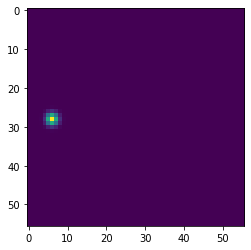

In [174]:
plt.imshow(hmp[0])

In [0]:
test_eq(np.unravel_index(hmp[0].argmax(), hmp[0].shape), (28,6))

Now we need to undo it

In [0]:
path = untar_data(URLs.MNIST_SAMPLE)

In [0]:
img = get_image_files(path)[0]

In [0]:
im = PILImage.create(img)

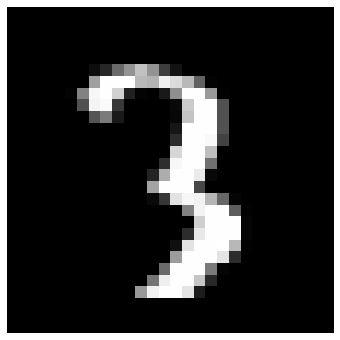

In [31]:
im.show(figsize=(6,6))

In [0]:
pnts = np.array([(0,28), (28,28), (28,0), (0,0), (14,14)])

In [0]:
hmp = _generate_targs(pnts, 1, (28,28))

Our "boxes" will be the size of the image since we have no target bodies

In [0]:
boxes = np.asarray([[0,0,28,28]])

In [0]:
#export
def get_points(x:tensor, size:array):
  "Extract a point from a heatmap and convert it"
  boxes = np.asarray([[0,0,size[1], size[0]]])
  pts = []
  for j, pnt in enumerate(x):
    pt = np.unravel_index(np.argmax(pnt), (size[0]//4, size[1]//4))
    y1 = int(pt[0] * 1. / (size[0]//4) * (boxes[0][3] - boxes[0][1]) + boxes[0][1])
    x1 = int(pt[1] * 1. / (size[1]//4) * (boxes[0][2] - boxes[0][0]) + boxes[0][0])
    pts.append([x1,y1])
  return pts

In [189]:
is_close(get_points(hmp, [28,28]), pnts, eps=4.01)

True

28x28 image size is off by ~4 pixels, let's try a larger image

In [0]:
pnts = np.array([(175, 160), (239, 162), (199, 199), (149, 121), (137, 78), 
        (166, 93), (281, 101), (312, 96), (296, 133)])

In [0]:
hmp = _generate_targs(pnts, 1, (375,500))

In [192]:
get_points(hmp, (500,375))

[[173, 160],
 [237, 164],
 [197, 200],
 [149, 120],
 [137, 80],
 [165, 92],
 [282, 100],
 [310, 96],
 [294, 132]]

In [193]:
is_close(get_points(hmp, (500,375)), pnts, eps=3)

True

On larger images (500,375), it's only off by 3 pixels, which is not bad

In [0]:
points = tensor([[0,0],
          [112,112],
          [0,112],
          [112,0]])

In [0]:
maps = _generate_targs(points, 1, (224,224))

In [0]:
test_eq(np.unravel_index(maps[0].argmax(), maps[0].shape), (0,0))
test_eq(np.unravel_index(maps[1].argmax(), maps[1].shape), (28,28))
test_eq(np.unravel_index(maps[2].argmax(), maps[2].shape), (28,0))
test_eq(np.unravel_index(maps[3].argmax(), maps[3].shape), (0,28))

Now let's integrate it into `fastai`. This is a simple transform for any `TensorPoint`.

In [0]:
#export
class TensorMaps(Transform):
  "Convert points into heatmaps"
  order = 99
  def __init__(self, sig=1): self.sig=sig

  def encodes(self, x:TensorPoint):
    x = np.array(x.get_meta('img_size'))
    x = (x+1)*x/2
    return _generate_targs(x, self.sig, x.get_meta('img_size'))

In [0]:
#export
GaussianBlock = TransformBlock(type_tfms=TensorPoint.create, item_tfms=[PointScaler, TensorMaps])